Student 1 : ORTEGA Marius \
Student 2 : TEILLET Louis 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   store_id    252108 non-null  object 
 1   date        252108 non-null  object 
 2   visitors    252108 non-null  int64  
 3   is_holiday  252108 non-null  bool   
 4   genre_name  252108 non-null  object 
 5   area_name   252108 non-null  object 
 6   latitude    252108 non-null  float64
 7   longitude   252108 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 13.7+ MB


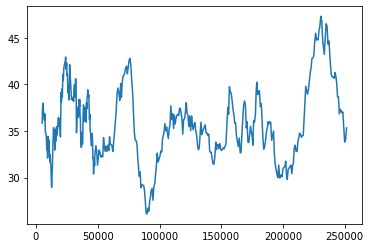

In [61]:
from river import datasets
import pandas as pd
import matplotlib.pyplot as plt

#%% Data importation

dataset = datasets.Restaurants()
dataset.download()

data = pd.read_csv("/Users/louisteillet/river_data/Restaurants/kaggle_recruit_restaurants.csv")

# %% Data description 

data.describe()

data.info()


data["date"] = pd.to_datetime(data["date"])
plt.plot(data[data["store_id"]=="air_04341b588bde96cd"]["visitors"].rolling(21).mean())

**Restaurant Dataset :**

The objective is to predict the number of visitors in the coming day for each restaurant.

In [62]:
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.stream import iter_pandas
from river import metrics



def print_progress(sample_id, MSE, MAE, R2):
    print(f'Samples processed: {sample_id}')
    print(MSE)
    print(MAE)
    print(R2)

def evaluate(stream, model, n_wait=1000, verbose=False):
    MSE = metrics.MSE()
    MAE = metrics.MAE()
    R2 = metrics.R2()
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        # Predict
        y_pred = model.predict_one(x)
        MSE.update(y_true=y, y_pred=y_pred)
        MAE.update(y_true=y, y_pred=y_pred)
        R2.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, MSE, MAE, R2)
            raw_results.append([model_name, i, MSE.get(), MAE.get(),R2.get()])
        # Learn (train)
        model.learn_one(x, y)
    print_progress(i, MSE, MAE, R2)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'MSE', 'MAE','R2'])

# Load the data, will be transformed into a stream later
df = pd.read_csv("/Users/louisteillet/river_data/Restaurants/kaggle_recruit_restaurants.csv")
df["date"] = pd.to_datetime(df["date"])
label_col = "visitors"
feature_cols = list(df.columns)
feature_cols.pop(2)
X = df[feature_cols]
Y = df[label_col]


In [63]:
from river import compose
from river import feature_extraction
from river import linear_model
from river import metrics
from river import preprocessing
from river import stats
from river import utils


def get_date_features(x):
    weekday =  x['date'].weekday()
    return {'weekday': weekday, 'is_weekend': weekday in (5, 6)}

lin_reg_model = compose.Pipeline(
    compose.FuncTransformer(get_date_features) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21)),

    compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression(l1=1)
)

lin_reg_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=lin_reg_model,verbose=False)

Samples processed: 1000
MSE: 228.83438
MAE: 10.509053
R2: 0.115915
Samples processed: 2000
MSE: 220.523547
MAE: 10.447955
R2: 0.241132
Samples processed: 3000
MSE: 251.807208
MAE: 9.853134
R2: 0.236625
Samples processed: 4000
MSE: 224.7294
MAE: 9.584665
R2: 0.281397
Samples processed: 5000
MSE: 208.394934
MAE: 9.172383
R2: 0.308587
Samples processed: 6000
MSE: 243.616083
MAE: 9.256028
R2: 0.277307
Samples processed: 7000
MSE: 230.909494
MAE: 9.154287
R2: 0.285807
Samples processed: 8000
MSE: 218.593955
MAE: 9.058098
R2: 0.295381
Samples processed: 9000
MSE: 208.817187
MAE: 8.982924
R2: 0.314529
Samples processed: 10000
MSE: 199.341096
MAE: 8.855512
R2: 0.328522
Samples processed: 11000
MSE: 195.790139
MAE: 8.885556
R2: 0.340784
Samples processed: 12000
MSE: 188.085328
MAE: 8.746536
R2: 0.347168
Samples processed: 13000
MSE: 185.453294
MAE: 8.756818
R2: 0.352018
Samples processed: 14000
MSE: 179.427965
MAE: 8.649474
R2: 0.359601
Samples processed: 15000
MSE: 179.921926
MAE: 8.729054
R2:

Here is the general pipeline we will use :
1. We add 2 columns, the first one indicates on which weekdays we are. The second one indicates if it's weekend or not.
2. We add 3 others columns : the rolling mean of visitors during the last 7, 14 and 21 days.
3. We remove all the useless columns
4. We normalize the data
5. We select a model

In [64]:
from river import tree


hoeffding_model = compose.Pipeline(
    compose.FuncTransformer(get_date_features) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21)),

    compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeRegressor(
        grace_period=100,
        max_depth = 2
    )
)

hoeffing_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=hoeffding_model,verbose=False)

Samples processed: 1000
MSE: 223.923833
MAE: 10.616561
R2: 0.134887
Samples processed: 2000
MSE: 222.548346
MAE: 10.566486
R2: 0.234164
Samples processed: 3000
MSE: 251.808629
MAE: 9.956212
R2: 0.236621
Samples processed: 4000
MSE: 224.010379
MAE: 9.638421
R2: 0.283696
Samples processed: 5000
MSE: 206.680933
MAE: 9.201455
R2: 0.314274
Samples processed: 6000
MSE: 243.598992
MAE: 9.313349
R2: 0.277358
Samples processed: 7000
MSE: 227.588535
MAE: 9.140735
R2: 0.296078
Samples processed: 8000
MSE: 215.27062
MAE: 9.024162
R2: 0.306094
Samples processed: 9000
MSE: 206.084258
MAE: 8.963407
R2: 0.3235
Samples processed: 10000
MSE: 197.116276
MAE: 8.844106
R2: 0.336016
Samples processed: 11000
MSE: 194.735107
MAE: 8.898835
R2: 0.344336
Samples processed: 12000
MSE: 187.383443
MAE: 8.77591
R2: 0.349605
Samples processed: 13000
MSE: 185.084304
MAE: 8.800282
R2: 0.353307
Samples processed: 14000
MSE: 178.932443
MAE: 8.690482
R2: 0.36137
Samples processed: 15000
MSE: 180.161078
MAE: 8.7792
R2: 0.3

In [69]:
adaptive_hoeffding_model = compose.Pipeline(
    compose.FuncTransformer(get_date_features) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21)),

    compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    tree.HoeffdingAdaptiveTreeRegressor(
        grace_period=100,
        max_depth = 2,
    )
)

adaptive_hoeffding_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=adaptive_hoeffding_model,verbose=False)

Samples processed: 1000
MSE: 228.167622
MAE: 10.821723
R2: 0.118491
Samples processed: 2000
MSE: 231.709913
MAE: 10.923686
R2: 0.202637
Samples processed: 3000
MSE: 260.327862
MAE: 10.215466
R2: 0.210794
Samples processed: 4000
MSE: 232.335434
MAE: 9.904222
R2: 0.257076
Samples processed: 5000
MSE: 214.010623
MAE: 9.458555
R2: 0.289955
Samples processed: 6000
MSE: 248.757974
MAE: 9.515566
R2: 0.262053
Samples processed: 7000
MSE: 232.404428
MAE: 9.337441
R2: 0.281183
Samples processed: 8000
MSE: 221.030833
MAE: 9.249029
R2: 0.287526
Samples processed: 9000
MSE: 214.422083
MAE: 9.246656
R2: 0.29613
Samples processed: 10000
MSE: 206.786129
MAE: 9.162617
R2: 0.303444
Samples processed: 11000
MSE: 204.671527
MAE: 9.215897
R2: 0.310881
Samples processed: 12000
MSE: 197.296072
MAE: 9.089788
R2: 0.315198
Samples processed: 13000
MSE: 195.465319
MAE: 9.105991
R2: 0.317036
Samples processed: 14000
MSE: 189.722605
MAE: 9.009068
R2: 0.322859
Samples processed: 15000
MSE: 192.530981
MAE: 9.13871
R

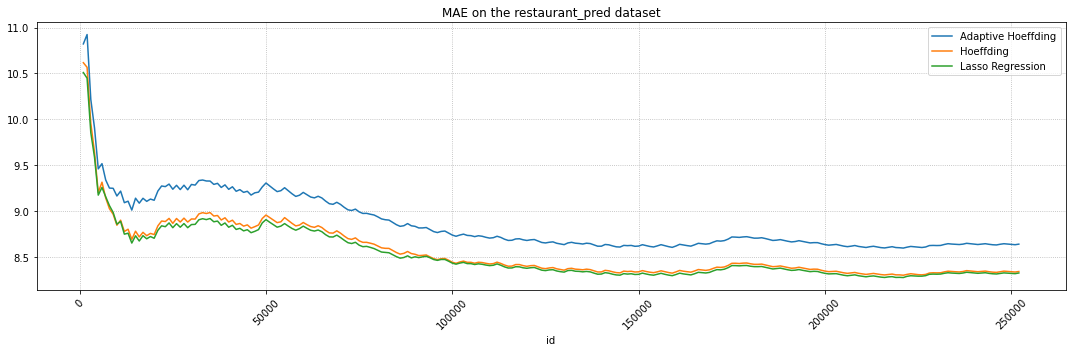

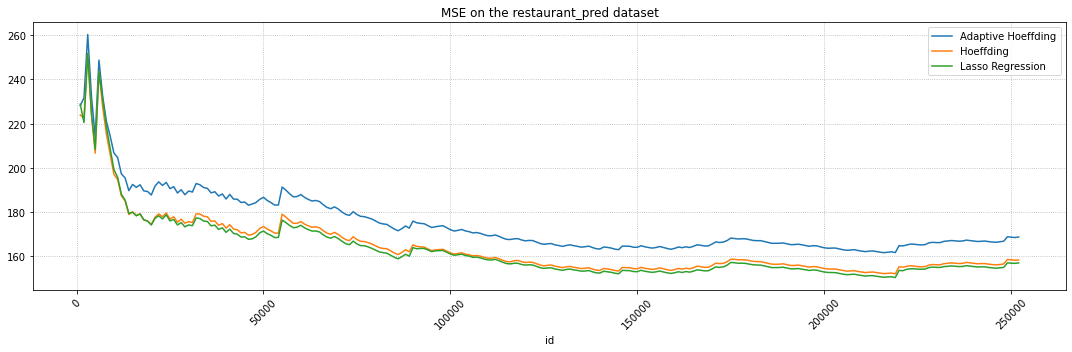

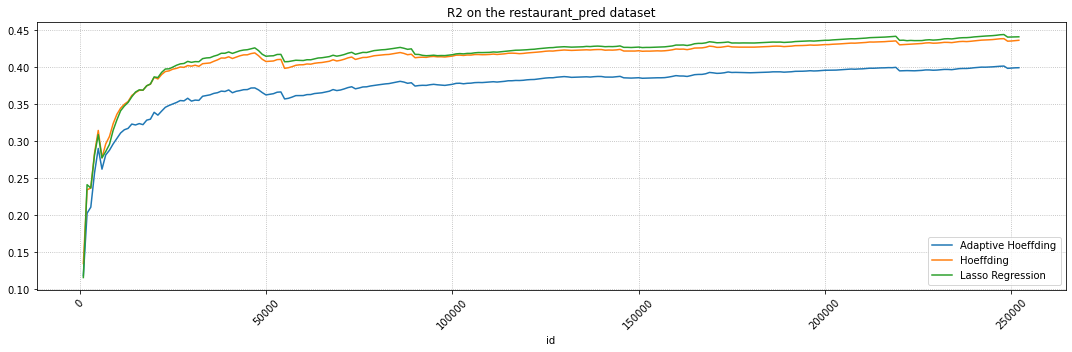

In [70]:
from matplotlib.backends.backend_pdf import PdfPages

dataset="restaurant_pred"
lin_reg_results["model"] = "Lasso Regression"
hoeffing_results["model"] = "Hoeffding"
adaptive_hoeffding_results["model"] = "Adaptive Hoeffding"
df = pd.concat([lin_reg_results, hoeffing_results, adaptive_hoeffding_results])
df.set_index('id', inplace=True)
grouped = df.groupby('model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    metric = "MAE"
    plt.figure(figsize=(15,5))
    grouped[metric].plot(rot=45, title="MAE")
    plt.legend( loc='best')
    plt.grid(linestyle=':')
    plt.title("MAE on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    plt.figure(figsize=(15,5))
    metric = "MSE"
    grouped[metric].plot(rot=45, title="metric")
    plt.legend(loc='best')
    plt.grid(linestyle=':')
    plt.title("MSE on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

    plt.figure(figsize=(15,5))
    metric = "R2"
    grouped[metric].plot(rot=45, title="metric")
    plt.legend(loc='best')
    plt.grid(linestyle=':')
    plt.title("R2 on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

In [68]:
df.loc[252000].set_index("model")

,MSE,MAE,R2
model,,,
Lasso Regression,157.054655,8.322963,0.440542
Hoeffding,158.376918,8.339000,0.435831
Adaptive Hoeffding,174.506913,8.804446,0.378373
